In [13]:
from torch.utils.data import DataLoader, Dataset
import torch
import argparse
import numpy as np
import glob
from sklearn.manifold import TSNE
from tqdm import tqdm
import random
import os
import sys
import torch.optim as optim
import torch.utils.data
import numpy as np
import torch.nn as nn
from torchvision import transforms
from torch.autograd import Function
from PIL import Image
import os
import pandas as pd
import argparse

In [21]:
class CNNModel(nn.Module):
    def __init__(self, code_size=512, n_class=10):
        super(CNNModel, self).__init__()
        
        self.feature_extractor_conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.ReLU(True),
            nn.Conv2d(64, 50, kernel_size=5),
            nn.BatchNorm2d(50),
            nn.Dropout2d(),
            nn.MaxPool2d(2),
            nn.ReLU(True)
        )

        self.feature_extractor_fc = nn.Sequential(
            nn.Linear(50 * 4 * 4, code_size),
            nn.BatchNorm1d(code_size),
            nn.Dropout(),
            nn.ReLU(True)
        )
        
        self.class_classifier = nn.Sequential(
            nn.Linear(code_size, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Linear(100, n_class),
            nn.LogSoftmax(dim=1)
        )

        self.domain_classifier = nn.Sequential(
            nn.Linear(code_size, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Linear(100, 2),
            nn.LogSoftmax(dim=1)
        )


    def forward(self, x, alpha=1.0):
        feature = self.feature_extractor_conv(x)
        feature = feature.view(-1, 50 * 4 * 4)
        feature = self.feature_extractor_fc(feature)
        
        return feature


class TrainSet(Dataset):
    def __init__(self, name, mode, transform):
        self.path = os.path.join(data_path, name, mode)
        self.data = sorted(os.listdir(self.path))
        df = pd.read_csv(os.path.join(data_path, name, mode + '.csv'))
        self.label = dict(zip(df.image_name, df.label))
        self.transform = transform
        
    def __getitem__(self, index):
        return self.transform(Image.open(os.path.join(self.path, self.data[index])).convert('RGB')), int(self.label[self.data[index]])

    def __len__(self):
        return len(self.data)

In [110]:
batch_size = 128
image_size = 28

target_tfm = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])

data_path = '../hw2_data/digits'
target_dataset = TrainSet('mnistm', 'test', target_tfm)
target_loader = DataLoader(target_dataset, batch_size = batch_size, shuffle = True, num_workers = 2)

In [105]:
model = CNNModel().cuda()
model.load_state_dict(torch.load('./model/svhn_mnistm_adaptation.pth'))

<All keys matched successfully>

In [ ]:
features, labels = [], []

In [111]:

for batch in tqdm(target_loader):
    imgs, lbls = batch
    with torch.no_grad():
        logits = model(imgs.cuda())
    labels += ['mnistm'] * len(logits)
    logits = np.squeeze(logits.cpu().numpy())
    features.extend(logits)
    

100%|███████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 32.88it/s]


In [112]:
print(len(features), len(labels))

36032 36032


In [89]:
colors_per_class = [list(np.random.choice(range(256), size=3)) for i in range(2)]

In [113]:
tsne = TSNE(n_components=2, init = 'pca').fit_transform(features)

/tmp2/b08902134/anaconda3/envs/miulab/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/tmp2/b08902134/anaconda3/envs/miulab/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


In [114]:
import matplotlib.pyplot as plt

def scale_to_01_range(x):
    value_range = (np.max(x) - np.min(x))
    starts_from_zero = x - np.min(x)

    return starts_from_zero / value_range

def visualize_tsne_points(tx, ty, labels):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    for idx,label in ['svhn', 'mnistm']:
        indices = [i for i, l in enumerate(labels) if l == label]

        current_tx = np.take(tx, indices)
        current_ty = np.take(ty, indices)

        color = np.array([colors_per_class[label][::-1]], dtype=np.float) / 255

        ax.scatter(current_tx, current_ty, c=color, label=label, s=5)
    ax.legend(loc='best')

    plt.show()

In [115]:
def visualize_tsne(tsne, labels, plot_size=1000, max_image_size=100):
    tx = tsne[:, 0]
    ty = tsne[:, 1]
    tx = scale_to_01_range(tx)
    ty = scale_to_01_range(ty)
    visualize_tsne_points(tx, ty, labels)

In [54]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

In [ ]:
colors_per_class = [list(np.random.choice(range(256), size=3)) for i in range(50)]

TypeError: list indices must be integers or slices, not str

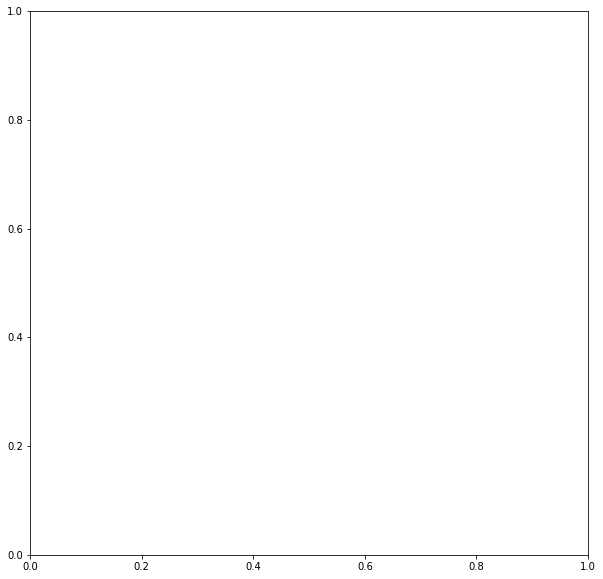

In [116]:
visualize_tsne(tsne, labels)